Import Statements

In [26]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
import requests
from config import consumer_key
import time
%matplotlib inline

variables

In [2]:
ticker = 'BABA'
t_intervals = 52
iterations = 1000000

Get the past 10 years of stock price close data for `ticker`

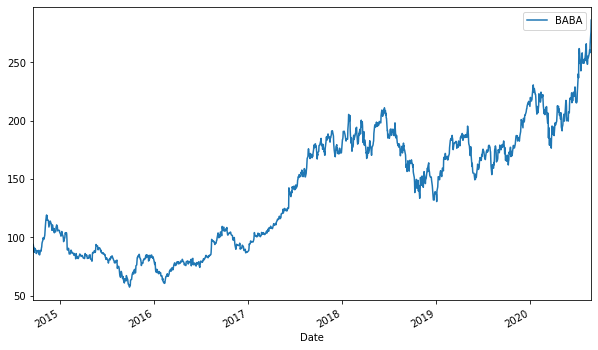

In [3]:
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1')['Adj Close']
data.plot(figsize=(10, 6));

Estimate historical log returns

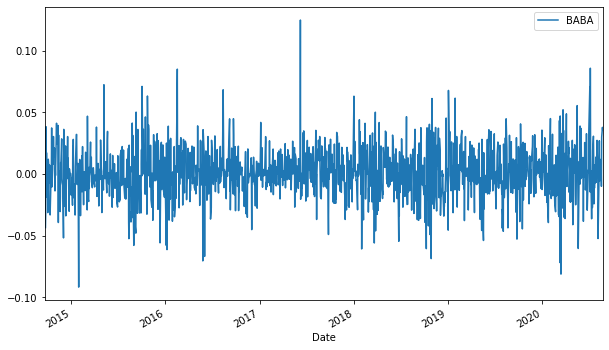

In [4]:
log_returns = np.log(1 + data.pct_change())
np_log_returns = log_returns.iloc[:,0].to_numpy()
log_returns.plot(figsize = (10, 6));

histogram of log returns

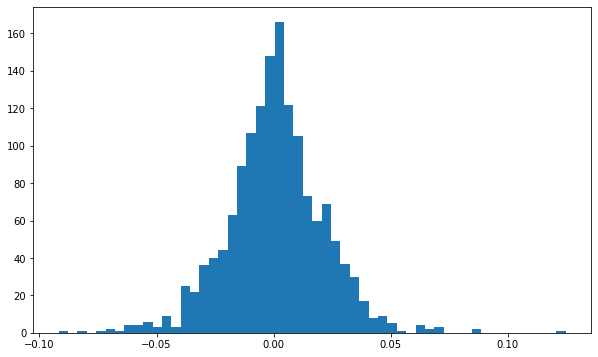

In [5]:
plt.figure(figsize=(10,6))
plt.hist(np_log_returns[1:], bins='auto');

run the simulations

In [6]:
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()

daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

plot the simulations if there aren't too many

In [7]:
if iterations <= 10000:
    plt.figure(figsize=(10,6))
    plt.plot(price_list);

a histogram of the prices after `t_intervals` days

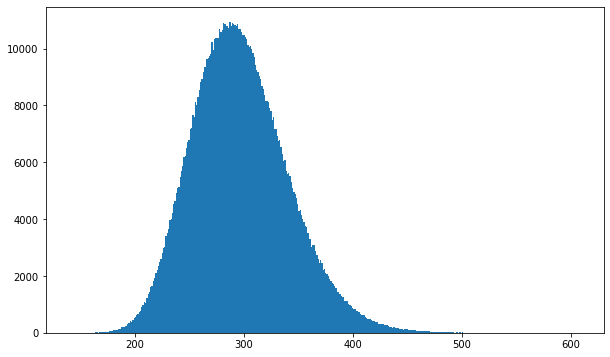

In [9]:
final_prices = price_list[-1]
plt.figure(figsize=(10,6))
plt.hist(final_prices, bins='auto');

calculate the cumulative probability that the stock will be between two values

In [10]:
lb = 255
lb_inclusive = True
ub = -1
ub_inclusive = False

total_prices = 0
counted = 0
for price in final_prices:
    lb_condition = lb == -1 or price > lb
    ub_condition = ub == -1 or price < ub
    if lb_condition and ub_condition:
        counted += 1
    elif lb_inclusive and price == lb:
        counted += 1
    elif ub_inclusive and price == ub:
        counted += 1
    total_prices += 1

counted / total_prices

0.832103

class to represent a bundle of option contracts with a function to calculate the p/l at a given price

In [30]:
class OptionsStrategy:
    def __init__(self, contracts, expM, expD, expY):
        priced_contracts = []
        for contract in contracts:
            option_sym = "{}_{}{}{}{}{}".format(
                ticker, expM, expD, expY, contract[1], contract[2]
            )
            endpoint = "https://api.tdameritrade.com/v1/marketdata/{}/quotes".format(
                option_sym
            )
            payload = { 'apikey': consumer_key }
            content = requests.get(url=endpoint, params=payload)
            td_data = content.json()[option_sym]
            priced_contracts.append(
                (contract[0], contract[1], td_data['mark'], contract[2])
            )
            
            quote_time = td_data['quoteTimeInLong']
            hours_since_quote = (time.time()*1000 - quote_time)/1000/60/60
            print("{} hours since quote".format(hours_since_quote))
            
        self.contracts = priced_contracts
        
    def reward(self, mkt):
        credit = -0.015 * len(self.contracts)

        for contract in self.contracts:
            if contract[0] == "LONG":
                credit -= contract[2]
                if contract[1] == "C" and mkt > contract[3]:
                    credit += mkt - contract[3]
                elif contract[1] == "P" and mkt < contract[3]:
                    credit += contract[3] - mkt
            elif contract[0] == "SHORT":
                credit += contract[2]
                if contract[1] == "C" and mkt > contract[3]:
                    credit -= mkt - contract[3]
                elif contract[1] == "P" and mkt < contract[3]:
                    credit -= contract[3] - mkt

        return credit

test a strategy

In [32]:
# ("LONG", "C", strike)

trial_strategy = OptionsStrategy([
    ("SHORT", "P", 280),
    ("LONG", "P", 275),
], 10, 16, 20)

8.199604320543077 hours since quote
8.199636921657987 hours since quote


plot the profit/loss diagram and breakeven point

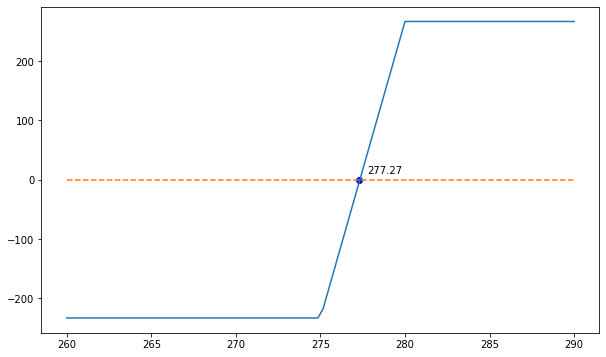

In [33]:
plt.figure(figsize=(10,6))
x = np.linspace(260, 290, 100)
breakeven_pl = 100
breakeven_price = 0
y = []
for xi in x:
    reward_i = trial_strategy.reward(xi) * 100
    y.append(reward_i)
    if abs(reward_i) < breakeven_pl:
        breakeven_price = xi
        breakeven_pl = abs(reward_i)
plt.annotate("{:.2f}".format(breakeven_price), (breakeven_price + 0.5, 10))
plt.plot(breakeven_price, 0, 'bo')
plt.plot(x, y);
plt.plot(x, [0]*len(x), '--');

calculate ev of the strategy

In [34]:
granularity = len(final_prices)

ev = 0
max_risk = 0
prob_success = 0
for price in final_prices:
    reward = trial_strategy.reward(price) * 100
    ev += reward / granularity
    if reward > 0:
        prob_success += 1
    if -1 * reward > max_risk:
        max_risk = -1 * reward
    
ev

92.59901743075551

capital risked

In [35]:
max_risk

233.00000000000125

expected return on capital risked

In [36]:
ev / max_risk

0.39742067566847644

probability of success

In [37]:
prob_success / granularity

0.652831